<a href="https://colab.research.google.com/github/kreshuklab/ADL4IA-2025/blob/main/U-Net_exercises/pytorch/2_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation on CIFAR10

In this exercise we will use data augmentation to increase the available training data and thus improve the network training performance. We will use the same network architecture as in the previous exercise.

## Downloading the data - Colab

In [1]:
# Uncomment if you use Colab
!pip install cifar2png
cifar_dir = './cifar10'
!cifar2png cifar10 {cifar_dir}
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/kreshuklab/ADL4IA-2025/refs/heads/main/U-Net_exercises/pytorch/utils.py

  Preparing metadata (setup.py) ... done
  Created wheel for cifar2png: filename=cifar2png-0.0.4-py3-none-any.whl size=5910 sha256=7a4501b90c27748d95f1b543e9b3fd0fe79b913806c30aba0a1985297720fe28
  Stored in directory: /root/.cache/pip/wheels/cb/2d/1c/b20d886bfeee732003537e1a30949e0a2d5295d674a13ca2a0
Successfully built cifar2png
cifar-10-python.tar.gz does not exists.
167kKB [00:09, 16.7kKB/s]              
Saving train images: 100% 50000/50000 [00:23<00:00, 2172.48it/s]
Saving test images: 100% 10000/10000 [00:05<00:00, 1976.95it/s]
--2025-05-13 09:05:50--  https://raw.githubusercontent.com/kreshuklab/ADL4IA-2025/refs/heads/main/U-Net_exercises/pytorch/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14051 (14K) [text/plain]
Saving to: ‘utils.py’



## Downloading the data - BARD

Data used in webinars is already downloaded and can be found in `"/scratch/denbi/k8s/ADL4IA_pre-course/"`

In [ ]:
cifar_dir = "/scratch/denbi/k8s/ADL4IA_pre-course/cifar10"

## Preparation

In [2]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import wandb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

In [3]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'.
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is not available, training will run on the CPU


In [4]:
# login to wandb for logging, you will need to create an account if you don't have one already
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gregoire-deletie (gregoire-deletie-hmm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [6]:
categories = os.listdir(os.path.join(cifar_dir, 'train'))
categories.sort()

In [9]:
images, labels = utils.load_cifar(os.path.join(cifar_dir, 'train'))
(train_images, train_labels,
 val_images, val_labels) = utils.make_cifar_train_val_split(images, labels)

100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


## Data Augmentation

The goal of data augmentation is to increase the amount of training data by transforming the input images in a way that they still resemble realistic images. Popular transformations used in data augmentation include rotations, image flips, color jitter or additive noise.
Here, we will start with two transformations:
- random flips along the vertical centerline
- random color jitters

In [81]:
# define random augmentations
import skimage.color as color
from torchvision.transforms import v2

def random_flip(image, target, probability=.5):
    """ Randomly mirror the image across the vertical axis.
    """
    if np.random.rand() < probability:
      image = np.array([np.fliplr(im) for im in image])
    return image, target

def random_rot(image, target, probability=.25):
    """ Randomly rotate the image by 90 degrees.
    """
    x=int(np.random.rand()/probability)
    #print(x)
    image = np.array([np.rot90(im,x) for im in image])
    return image, target

def random_crop(image, target, probability=.5):
    """ Randomly rotate the image by 90 degrees.
    """
    tr=v2.RandomResizedCrop(size=image.shape[1:3],scale=(0.7, 0.9), antialias=True)
    if np.random.rand() < probability:
      image = tr(image)
    return image, target

def random_color_jitter(image, target, probability=.5):
  """ Randomly jitter the saturation, hue and brightness of the image.
  """
  if np.random.rand() > probability:
    # skimage expects WHC instead of CHW
    image = image.transpose((1, 2, 0))
    # transform image to hsv color space to apply jitter
    image = color.rgb2hsv(image)
    # compute jitter factors in range 0.66 - 1.5
    jitter_factors = 1.5 * np.random.rand(3)
    jitter_factors = np.clip(jitter_factors, 0.66, 1.5)
    # apply the jitter factors, making sure we stay in correct value range
    image *= jitter_factors
    image = np.clip(image, 0, 1)
    # transform back to rgb and CHW
    image = color.hsv2rgb(image)
    image = image.transpose((2, 0, 1))
  return image, target

In [82]:
# create training dataset with augmentations
from functools import partial
train_trafos = [
    utils.to_channel_first,
    utils.normalize,
    random_color_jitter,
    random_flip,
    random_rot,
    utils.to_tensor,
    random_crop
]
train_trafos = partial(utils.compose, transforms=train_trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                            transform=train_trafos)

# we don't use data augmentations for the validation set
val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                          transform=utils.get_default_cifar_transform())

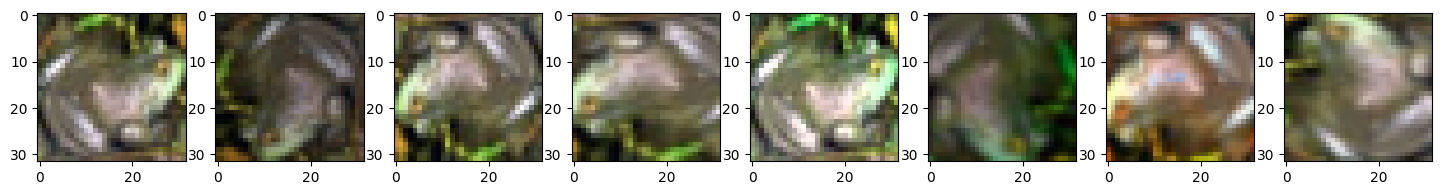

In [86]:
# sample augmentations
def show_image(ax, image):
    # need to go back to numpy array and WHC axis order
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)

n_samples = 8
image_id = 0
fig, ax = plt.subplots(1, n_samples, figsize=(18, 4))
for sample in range(n_samples):
    image, _ = train_dataset[0]
    show_image(ax[sample], image)

In [87]:
# we reuse the model from the previous exercise
# if you want you can also use a different CNN architecture that
# you have designed in the tasks part of that exercise
model = utils.SimpleCNN(10)
model = model.to(device)

In [88]:
# instantiate loaders and optimizer and start tensorboard
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25)
optimizer = Adam(model.parameters(), lr=1.e-3)


In [90]:
# we have moved all the boilerplate for the full training procedure to utils now
n_epochs = 10
utils.run_cifar_training(model, optimizer,
                         train_loader, val_loader,
                         device=device, name='da1',
                         n_epochs=n_epochs)

learning-rate,▁
train-loss,▅▃▃▃▄▄▄▂▃▄▃▃▃▂▃▃▃▃▄▄▄▃▅▂▁▂▄▃▄▃▃▄▃▃▁█▂▅▄▂
learning-rate,0.001
train-loss,2.34468


  0%|          | 0/10 [01:59<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# evaluate the model on test data
test_dataset = utils.make_cifar_test_dataset(cifar_dir)
test_loader = DataLoader(test_dataset, batch_size=25)
predictions, labels = utils.validate(model, test_loader, nn.NLLLoss(),
                                     device, step=0, logging=False)

In [ ]:
print("Test accuracy:")
accuracy = metrics.accuracy_score(labels, predictions)
print(accuracy)

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(labels, predictions, categories, ax)

## Normalization layers

In addition to convolutional layers and pooling layers, another important part of neural networks are normalization layers.

These layers keep their input normalized using a learned normalization. The first type of normalization introduced has been [BatchNorm](https://arxiv.org/abs/1502.03167), which we will now add to the CNN architecture from the previous exercise.

In [ ]:
import torch.nn.functional as F

class CNNBatchNorm(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        # the convolutions
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        # the pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # the normalization layers
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(24)

        # the fully connected part of the network
        # after applying the convolutions and poolings, the tensor
        # has the shape 24 x 6 x 6, see below
        self.fc = nn.Sequential(
            nn.Linear(24 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, self.n_classes)
        )
        self.activation = nn.LogSoftmax(dim=1)

    def apply_convs(self, x):
      # input image has shape 3 x  32 x 32
      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      # shape after conv: 12 x 28 x 28
      # shape after pooling: 12 x 14 X 14
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      # shape after conv: 24 x 12 x 12
      # shape after pooling: 24 x 6 x 6
      return x

    def forward(self, x):
        x = self.apply_convs(x)
        x = x.view(-1, 24 * 6 * 6)
        x = self.fc(x)
        x = self.activation(x)
        return x

In [ ]:
# instantiate model and optimizer
model = CNNBatchNorm(10)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1.e-3)

In [ ]:
n_epochs = 10
utils.run_cifar_training(model, optimizer,
                         train_loader, val_loader,
                         device=device, name='batch-norm',
                         n_epochs=n_epochs)

In [ ]:
model = utils.load_checkpoint("best_checkpoint_batch-norm.tar", model, optimizer)[0]

In [ ]:
predictions, labels = utils.validate(model, test_loader, nn.NLLLoss(),
                                     device, step=0, logging=False)

print("Test accuracy:")
accuracy = metrics.accuracy_score(labels, predictions)
print(accuracy)

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(labels, predictions, categories, ax)

## Tasks and Questions

Tasks:
- Implement one or two additional augmentations and train the model again using these. You can use [the torchvision transformations](https://pytorch.org/vision/stable/transforms.html) for inspiration.

Questions:
- Compare the model results in this exercise.
- Can you think of any transformations that make use of symmetries/invariances not present here but present in other kinds of images (e.g. biomedical images)?

Advanced:
- Check out the other [normalization layers available in pytorch](https://pytorch.org/docs/stable/nn.html#normalization-layers). Which layers could be beneficial to BatchNorm here? Try training with them and see if this improves performance further.